# Implementing Decision Tree on Iris Dataset

### Note:
In the below code I tried to print the decision tree based on the continuous data. The code will not predict or fit the training data. Instead of that it will simply print the node data and the tree formed by using the data.

In [1]:
from sklearn import datasets
import math
import numpy as np
import pandas as pd
import graphviz

### Uniq_Couter

Function return the count of unique values present in y (Result)

In [2]:
def uniq_counter(y):
    set_y=set(y)
    count_dic={}
    for i in set_y:
        count_dic[i]=(i==y).sum()
    return count_dic

### Entropy

$$entropy=-\sum_{i}P_i log_2(P_i)$$ 

Entropy is calculated using the above formula. Where $P_i$ is the probability of getting i

In [3]:
def entropy(y):
    # Calling uniq_counter which will return the count of each feature present in y.
    pos_output=uniq_counter(y)
    ent=0
    for i in pos_output:
        p_i = pos_output[i]/len(y)
        ent+= -p_i*math.log(p_i,2)
    return ent

### Split Info

$$SplitInfo = \sum_{j=1}^{n}(D_j/D)(log_2(D_j/D))$$

Above formula is used to calculate split info.<br>
Where :- <br>
n = no. of node into which we have split <br>
D = no. of element in original node on which split happened <br>
$D_j$ = no. of element in jth node

In [4]:
def split_info(node1_len,node2_len):
    if node1_len==0 or node2_len==0:
        return 0
    total_len=node1_len+node2_len
    split_info=(-node1_len*math.log((node1_len/total_len),2)/total_len)+(-node2_len*math.log((node2_len/total_len),2)/total_len)
    return split_info

### Info Gain

Info_gain = Info_of_parent_node - Info_of_child <br>
Info_of_parent_node = entropy_of_parent <br>
Info_of_child = $\sum_{child}$ (total_child_node_feature * entropy_of_child / total_parent_node_feature)

In [5]:
def info_gain(df, feature_selected, point):
    df_node1=df[df[feature_selected]<=point]
    df_node2=df[df[feature_selected]>point]
    info_req=entropy(df['Result'])
    
    info_node1=len(df_node1)*entropy(df_node1['Result'])/len(df)
    info_node2=len(df_node2)*entropy(df_node2['Result'])/len(df)
    total_info=info_node1+info_node2
    
    info_gain=info_req-total_info
    
    # Calling split_info here with arguments as the child nodes length
    spl_info=split_info(len(df_node1['Result']),len(df_node2['Result']))
    
    #Returning the info_gain and split_info 
    return info_gain,spl_info

### Gain Ratio

Gain Ratio = Info Gain / Split Info

In [6]:
def gain_ratio(df,feature_selected,point):
    i_gain, spl_info= info_gain(df,feature_selected,point)
    if spl_info==0:
        # Returning -infinity to handle n/0 error
        return -math.inf
    return i_gain/spl_info

### Split Points

This function returns a list of points on which split can be done. Input is the column of feature on which we are trying to split.

In [7]:
def split_points(data):
    points=[]
    # Sorting so that all our data points lie in a single line
    data=data.sort_values()
    # finding only unique data points so that our split points will be unique too
    unique_data=data.unique()
    for i in range(len(unique_data)-1):
        # Talking avg of the 2 data points at a time and appending in to our split points list
        points.append(((unique_data[i]+unique_data[i+1])/2).round(2))
    return points

### Create Data Frame

As our whole program is written considering the data frame of iris, below function will convert our data to a single data frame.

In [8]:
def create_data_frame(x,y,col_name):
    df=pd.DataFrame(x,columns=col_name)
    df['Result']=y
    return df

### Build Tree

Below mentioned class is used to store all the nodes in the form of a dictionary, print the required data and finally print the tree.

In [9]:
class buildTree:
    
    # counter will store the number of count of nodes and dic will store all the data of the different nodes 
    # where key will be the counter of the node and value will be the data
    counter=0
    dic={}
    
    def __init__(self,data):
        self.data=data
        buildTree.counter+=1
        self.create_dic(data)
        self.print_data(self.data)
        
    # print_data will print the node data in our required format
    def print_data(self,data):
        print('Level ',data['level'])
        for i in data['fl_name']:
            print('Count of',i,'= ',data['fl_name'][i])
        print('Current Entropy =',data['ent'])
        if data['node']=='leaf':
            print('Reached Leaf Node')
        elif data['node']=='leaf2':
            print('Reached Leaf Node, No Feature to Split Further')
        elif data['node']=='parent':
            print('Splitting on feature',data['prefered_feature'],'at ',data['splitat'],'with gain ratio',data['g_r'])
        print('------------------------------------------------------------')
        
    # create_dic will add the node data to the dic where key will be the count of node and value will be the data
    def create_dic(self,data):
        buildTree.dic[buildTree.counter]=data
        child=buildTree.counter
        
        # Adding a relation key in our data
        # Here the idea is that the node should not be at level 0 as level 0 node is not a child node
        # Iterate in reverse order in dic and find the first parent node whose level is smaller than the current node
        # Store the node number in 'rel' and break to create the relation of child to parent node
        if data['level']!=0:
            for i in sorted(buildTree.dic.keys(),reverse=True):
                if buildTree.dic[i]['level']<data['level'] and buildTree.dic[i]['node']=='parent':
                    buildTree.dic[child]['rel']=str(i)
                    break
                    
    # Returns the tree data in the form of dictionary
    @classmethod
    def get_dic(self):
        return buildTree.dic
    
    # As our counter and dic are on class level so it become necessary 
    # to set them to 0 and empty dictionary before storing anything.
    @classmethod
    def refresh_dic(self):
        buildTree.counter=0
        buildTree.dic={}
        
    # Below code will return the tree in the form of dot data
    @classmethod
    def treebuilder(self):
        
        # Creating Digraph object
        dot=graphviz.Digraph()
        dot.node_attr['shape'] = 'rectangle'
        
        # Iterating in dic
        for i in buildTree.dic:
            
            # box will store all the data which we want to print in our node of the tree
            box=''
            if buildTree.dic[i].get('splitat') is not None:
                box=box+buildTree.dic[i].get('prefered_feature')+' <= '+str(buildTree.dic[i].get('splitat'))+'\n'
            else:
                box+='Leaf Node \n'
            new_str1=''
            new_str2=''
            for j in buildTree.dic[i]['fl_name']:
                new_str1=new_str1+','+j+' '
                new_str2=new_str2+','+str(buildTree.dic[i]['fl_name'][j])
            box=box+new_str1.strip(',')+'\n'+new_str2.strip(',')+'\n'+'entropy = '+str(buildTree.dic[i]['ent'].round(4))+'\n'
            
            if buildTree.dic[i]['node']=='leaf':
                for j in buildTree.dic[i].get('fl_name').keys():
                    box=box+' output - '+j
            if buildTree.dic[i]['node']=='leaf2':
                box=box+' output - '+max(buildTree.dic[i]['fl_name'],key=buildTree.dic[i]['fl_name'].get)
            
            # Adding the node with number as node number and node data as box
            dot.node(str(i),box)
            
            # Adding relations or edges to the node
            if buildTree.dic[i].get('rel') is not None:
                dot.edge(str(buildTree.dic[i].get('rel')),str(i))
        return dot

### Decision Tree

Below Function is the function which is doing all the recursion and making the decision by taking the help of the above mentioned functions.<br>
Stoping Conditions<br>
* If the result has only 1 unique value
* If there are no feature to split upon  
<br>
Else Continue splitting based on the below Conditions<br>

* Choose a feature to split upon
* Identify the points on which we can split
* Identify the point where we get max gain
* Repeat the same for remaining feature
* Pick the point and feature where we get the max gain

In [10]:
def dec_tree(df,fl_name,level=0):
    
    # uniq_y -> all the unique results of our dataframe
    uniq_y=uniq_counter(df['Result'])
    
    # dic will store all the required node info
    dic={}
    
    # Removing result column from features list
    features=df.columns[:-1]
    
    #First stoping condition
    if len(uniq_y)==1:
        
        # Storing all node info in dic
        dic['level']=level
        new_dic={}
        for i in uniq_y:
            new_dic[fl_name[i]]=uniq_y[i]
        dic['fl_name']=new_dic
        dic['ent']=entropy(df['Result'])
        dic['node']='leaf'
        
        # Calling buildTree to store the node info and add it in our tree
        buildTree(dic)
        
    # Second stopping condition
    elif len(df.columns)-1==0:
        
        # Storing all node info in dic
        dic['level']=level
        new_dic={}
        for i in uniq_y:
            new_dic[fl_name[i]]=uniq_y[i]
        dic['fl_name']=new_dic
        dic['ent']=entropy(df['Result'])
        dic['node']='leaf2'
        
        # Calling buildTree to store the node info and add it in our tree
        buildTree(dic)
      
    # To continue our recursion
    else:
        
        # Initially max_gain, prefered_feture, split_at are set to None which will have when we get our first node 
        # and then changes based on the gain ratio
        max_gain=None
        prefered_feature=None
        split_at=None
        
        # Iterating over the features available to split
        for i in features:
            
            # Getting the split poinst
            sp_points=split_points(df[i])
            
            # Iterating over the split points and finding the point and feture for which we get the maximum gain
            for j in sp_points:
                g_r=gain_ratio(df,i,j)
                if max_gain==None:
                    max_gain=g_r
                    prefered_feature=i
                    split_at=j
                elif max_gain<g_r:
                    max_gain=g_r
                    prefered_feature=i
                    split_at=j
                    
        # Storing the node info in the dic based on the feature and split point found in earlier step
        dic['level']=level
        new_dic={}
        for i in uniq_y:
            new_dic[fl_name[i]]=uniq_y[i]
        dic['fl_name']=new_dic
        dic['ent']=entropy(df['Result'])
        dic['node']='parent'
        dic['splitat']=split_at
        dic['prefered_feature']=prefered_feature
        dic['g_r']=max_gain
        
        # Calling buildTree to add the node in the tree
        buildTree(dic)
        
        # Spliting our dataframe into two new dataframes based on the feature and split point found earlier
        node_1=df[df[prefered_feature]<=split_at]        
        node_2=df[df[prefered_feature]>split_at]

        
        # Recursion call by droping the column on which we have already split and increasing the level
        dec_tree(node_1.drop([prefered_feature],axis=1),fl_name,level+1)
        dec_tree(node_2.drop([prefered_feature],axis=1),fl_name,level+1)

### Export Tree

Below function is used to save our tree in pdf format

In [11]:
def export_tree(dot,name):
    dot.render(name)
    return True

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Truth table dataset

In [12]:
x = np.array([[1,1],
              [0,1],
              [1,0],
              [0,0]])
y = np.array([1,
              1,
              1,
              0]) 
truth=create_data_frame(x,y,['X1','X2'])

In [13]:
buildTree.refresh_dic()
dec_tree(truth,fl_name=['False','True'])
dot=buildTree.treebuilder()

Level  0
Count of False =  1
Count of True =  3
Current Entropy = 0.8112781244591328
Splitting on feature X1 at  0.5 with gain ratio 0.31127812445913283
------------------------------------------------------------
Level  1
Count of False =  1
Count of True =  1
Current Entropy = 1.0
Splitting on feature X2 at  0.5 with gain ratio 1.0
------------------------------------------------------------
Level  2
Count of False =  1
Current Entropy = 0.0
Reached Leaf Node
------------------------------------------------------------
Level  2
Count of True =  1
Current Entropy = 0.0
Reached Leaf Node
------------------------------------------------------------
Level  1
Count of True =  2
Current Entropy = 0.0
Reached Leaf Node
------------------------------------------------------------


In [14]:
export_tree(dot,'truth_final_tree')

True

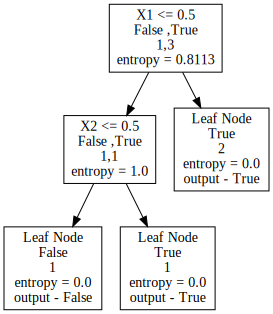

In [15]:
dot

### Iris Dataset

In [16]:
iris=datasets.load_iris()
df=create_data_frame(iris.data,iris.target,iris.feature_names)
buildTree.refresh_dic()
dec_tree(df,['setosa', 'versicolor', 'virginica'])
dot=buildTree.treebuilder()

Level  0
Count of setosa =  50
Count of versicolor =  50
Count of virginica =  50
Current Entropy = 1.584962500721156
Splitting on feature petal length (cm) at  2.45 with gain ratio 0.9999999999999999
------------------------------------------------------------
Level  1
Count of setosa =  50
Current Entropy = 0.0
Reached Leaf Node
------------------------------------------------------------
Level  1
Count of versicolor =  50
Count of virginica =  50
Current Entropy = 1.0
Splitting on feature petal width (cm) at  1.75 with gain ratio 0.6933647985912663
------------------------------------------------------------
Level  2
Count of versicolor =  49
Count of virginica =  5
Current Entropy = 0.44506485705083865
Splitting on feature sepal length (cm) at  7.1 with gain ratio 0.4975543406112372
------------------------------------------------------------
Level  3
Count of versicolor =  49
Count of virginica =  4
Current Entropy = 0.3860189005698934
Splitting on feature sepal width (cm) at  2.8

In [17]:
export_tree(dot,'iris_final_tree')

True

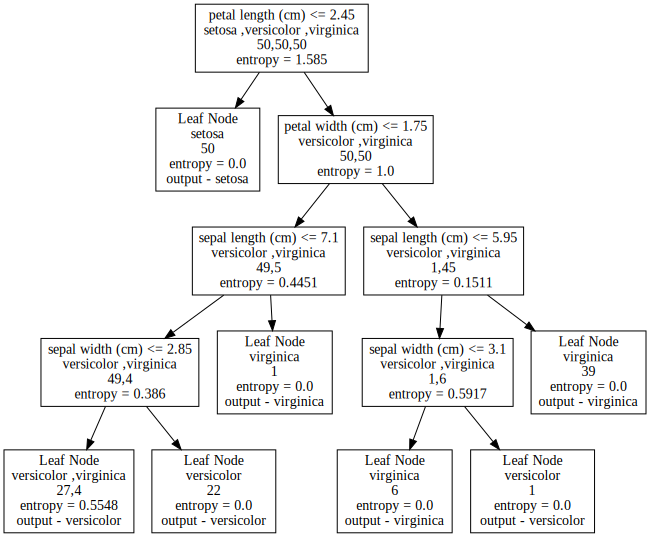

In [18]:
dot